参考文献: <https://qiita.com/cvusk/items/61cdbce80785eaf28349>

In [1]:
import os
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import model_selection
from sklearn import preprocessing
import IPython.display as ipd

In [2]:
base_dir = "./"
# directory for ESC-50 dataset
esc_dir = os.path.join(base_dir, "ESC-50-master")
meta_file = os.path.join(esc_dir, "meta/esc50.csv")
audio_dir = os.path.join(esc_dir, "audio/")

meta_data = pd.read_csv(meta_file)
data_size = meta_data.shape
print(data_size)

class_dict = {}
for i in range(data_size[0]):
    if meta_data.loc[i, "target"] not in class_dict.keys():
        class_dict[meta_data.loc[i, "target"]] = meta_data.loc[i, "category"]

(2000, 7)


wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


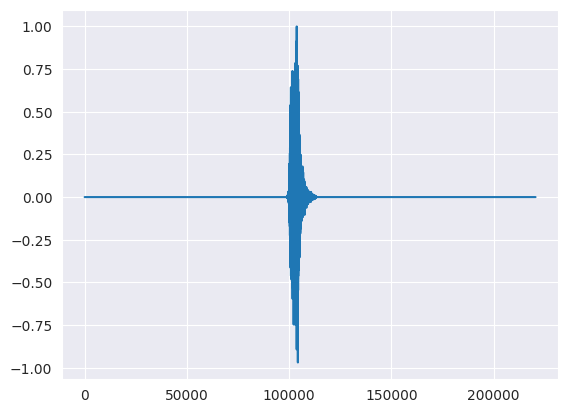

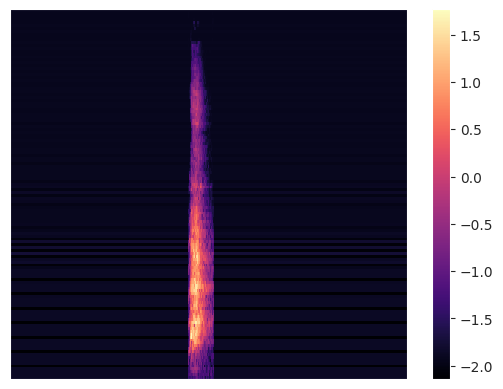

In [3]:
def load_wave_data(audio_dir, file_name):
    file_path = os.path.join(audio_dir, file_name)
    x, fs = librosa.load(file_path, sr=44100)
    return x, fs

def calculate_melsp(x, n_fft=1026, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft = n_fft, hop_length = hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S = log_stft, n_mels = 128)
    return melsp

def show_wave(x):
    plt.plot(x)
    plt.show()

def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, sr=fs)
    plt.colorbar()
    plt.show()

x, fs = load_wave_data(audio_dir, meta_data.loc[0,"filename"])
melsp = calculate_melsp(x)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x.shape, melsp.shape, fs))
show_wave(x)
show_melsp(melsp, fs)

In [4]:
# data augmentation: add white noise
def add_white_noise(x, rate=0.002):
    return x + rate*np.random.randn(len(x))

# data augmentation: shift sound in timeframe
def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

# data augmentation: stretch sound
def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(x, rate = rate)
    if len(x)>input_length:
        return x[:input_length]
    else:
        return np.pad(x, (0, max(0, input_length - len(x))), "constant")

In [5]:
import librosa
import librosa.display

# change wave data to mel-stft
def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=128)
    return melsp

In [6]:
# get training dataset and target dataset
x = list(meta_data.loc[:,"filename"])
y = list(meta_data.loc[:, "target"])

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.25, stratify=y)
print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(len(x_train),
                                                                len(y_train),
                                                                len(x_test),
                                                                len(y_test)))

"""output
x train:1500
y train:1500
x test:500
y test:500
"""

# showing the classes are equally splitted
a = np.zeros(50)
for c in y_test:
    a[c] += 1
print(a)

"""output
[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
"""

x train:1500
y train:1500
x test:500
y test:500
[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


'output\n[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.\n 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.\n 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]\n'

In [7]:
freq = 128
time = 1723

# save wave data in npz, with augmentation
def save_np_data(filename, x, y, aug=None, rates=None):
    np_data = np.zeros(freq*time*len(x)).reshape(len(x), freq, time)
    np_targets = np.zeros(len(y))
    for i in range(len(y)):
        _x, fs = load_wave_data(audio_dir, x[i])
        if aug is not None:
            _x = aug(x=_x, rate=rates[i])
        _x = calculate_melsp(_x)
        np_data[i] = _x
        np_targets[i] = y[i]
    np.savez(filename, x=np_data, y=np_targets)

In [8]:
# save test dataset
if not os.path.exists("esc_melsp_test.npz"):
    save_np_data("esc_melsp_test.npz", x_test,  y_test)

In [9]:
# save raw training dataset
if not os.path.exists("esc_melsp_train_raw.npz"):
    save_np_data("esc_melsp_train_raw.npz", x_train,  y_train)

In [10]:
# save training dataset with white noise
if not os.path.exists("esc_melsp_train_wn.npz"):
    rates = np.random.randint(1,50,len(x_train))/10000
    save_np_data("esc_melsp_train_wn.npz", x_train,  y_train, aug=add_white_noise, rates=rates)

In [11]:
# save training dataset with sound shift
if not os.path.exists("esc_melsp_train_ss.npz"):
    rates = np.random.choice(np.arange(2,6),len(y_train))
    save_np_data("esc_melsp_train_ss.npz", x_train,  y_train, aug=shift_sound, rates=rates)

In [12]:
# save training dataset with stretch
if not os.path.exists("esc_melsp_train_st.npz"):
    rates = np.random.choice(np.arange(80,120),len(y_train))/100
    save_np_data("esc_melsp_train_st.npz", x_train,  y_train, aug=stretch_sound, rates=rates)

In [13]:
# save training dataset with combination of white noise and shift or stretch
if not os.path.exists("esc_melsp_train_com.npz"):
    np_data = np.zeros(freq*time*len(x_train)).reshape(len(x_train), freq, time)
    np_targets = np.zeros(len(y_train))
    for i in range(len(y_train)):
        x, fs = load_wave_data(audio_dir, x_train[i])
        x = add_white_noise(x=x, rate=np.random.randint(1,50)/1000)
        if np.random.choice((True,False)):
            x = shift_sound(x=x, rate=np.random.choice(np.arange(2,6)))
        else:
            x = stretch_sound(x=x, rate=np.random.choice(np.arange(80,120))/100)
        x = calculate_melsp(x)
        np_data[i] = x
        np_targets[i] = y_train[i]
    np.savez("esc_melsp_train_com.npz", x=np_data, y=np_targets)

In [14]:
# PyTorch imports for CNN
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
import torchvision.transforms as transforms

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [18]:
# CNN Model for Audio Classification
class AudioCNN(nn.Module):
    def __init__(self, num_classes=50):
        super(AudioCNN, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Third convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Fourth convolutional block
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)

        # Dropout layer
        self.dropout = nn.Dropout(0.5)

        # Placeholder for fully connected layers - will be initialized in forward pass
        self.fc1 = None
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        # First block
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        # Second block
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        # Third block
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        # Fourth block
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Initialize fc1 with correct input size on first forward pass
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), 512).to(x.device)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

# Initialize the model
model = AudioCNN(num_classes=50).to(device)
print(model)


AudioCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [19]:
# Load pre-prepared datasets
print("Loading pre-prepared datasets...")

# Load training dataset (using combined dataset that includes all augmentations)
train_data = np.load('esc_melsp_train_com.npz')
X_train = train_data['x']
y_train = train_data['y']

# Load test dataset
test_data = np.load('esc_melsp_test.npz')
X_test = test_data['x']
y_test = test_data['y']

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

print("Datasets loaded successfully!")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).unsqueeze(1)  # Add channel dimension
X_test_tensor = torch.FloatTensor(X_test).unsqueeze(1)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")


Loading pre-prepared datasets...
Training data shape: (1500, 128, 1723)
Training labels shape: (1500,)
Test data shape: (500, 128, 1723)
Test labels shape: (500,)
Datasets loaded successfully!
Training batches: 47
Test batches: 16


In [ ]:
# Training function
def train_model(model, train_loader, test_loader, num_epochs=50):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total_test += target.size(0)
                correct_test += (predicted == target).sum().item()

        test_accuracy = 100 * correct_test / total_test

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        scheduler.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Train Acc: {train_accuracy:.2f}%, '
                  f'Test Acc: {test_accuracy:.2f}%')

    return train_losses, train_accuracies, test_accuracies

# Train the model
print("Starting training...")
train_losses, train_accuracies, test_accuracies = train_model(model, train_loader, test_loader, num_epochs=50)


Starting training...
Epoch [1/50], Train Loss: 3.8791, Train Acc: 2.20%, Test Acc: 4.80%
Epoch [6/50], Train Loss: 2.7373, Train Acc: 21.87%, Test Acc: 33.40%
Epoch [11/50], Train Loss: 2.2483, Train Acc: 33.67%, Test Acc: 38.60%
Epoch [16/50], Train Loss: 1.7642, Train Acc: 47.67%, Test Acc: 43.40%


In [ ]:
# Plot training results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")


In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions for test set
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(all_targets, all_predictions)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(all_targets, all_predictions))


In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'audio_cnn_model.pth')
print("Model saved as 'audio_cnn_model.pth'")

# Function to load the model
def load_model(model_path):
    model = AudioCNN(num_classes=50).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

print("CNN model training complete!")
